In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 2

(12p)

**a)** We are observing a time-series $y_t$, $t= 1,2,3, \ldots$ which we model as an AR(p) process observed through noise, that is,
$$
    \begin{cases} \alpha_{t+1} = \sum_{i=1}^{p} a_i \alpha_{t-i} + \eta_r, & \eta_t \sim \mathcal{N}(0, \sigma^2_{\eta}), \\ y_t = b \alpha_t + \varepsilon_t, & \varepsilon_t \sim \mathcal{0,\sigma^2_{\varepsilon}}, \end{cases}
$$
where $a_1, a_2, \ldots, a_p, b, \sigma^2_{\eta}$, and $\sigma^2_{\varepsilon}$ are constants assumed to be known (for now).

To work with this model we need to write it on __state-space form__, write down the full model on state-space form, with a highdimensional hidden AR(1) process. Specify all of the involved matrices and vectors.

<div style="text-align: right"> (2p) </div>

**Solution:**

Forllow the course slides, we can transfer those equation to $\alpha_{t}=T\alpha_{t-1}+R\eta_t$, the model can be seen in next code chunk

----

**b)** In the file `data_problem2.csv` the observations from this model is found. From previous experience you set $p = 3$ with $a_1 = 0.55, a_2 = 0.75, a_3 = -0.75, b = 3, \sigma_{\eta}^2 = 0.5^2$, and $\sigma^2_{\varepsilon} = 0.8^2$.

Set the initial distribution to be zero mean and covariance that is an identity matrix with variance 10 for each component.

Using the provided data, provide a plot the estimated values of $\hat{y}_{t | t-1}$ together with $\pm$ 1 standard deviation for each $t = 1,2,3,\ldots$.

Also provide a plot of $\alpha_{t} + \alpha_{t-1} + \alpha_{t-2}$ together with $\pm$ 1 standard deviation for each $t = 1, 2, 3, \ldots$.

_hint: the Kalman filter is available in the `tssltools.py`_
<div style="text-align: right"> (3p) </div>

**Solution:**

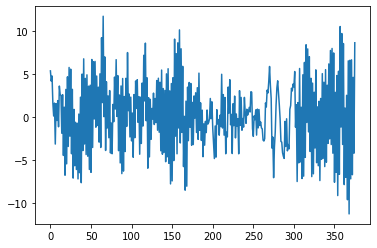

In [3]:
data = pd.read_csv('data_problem2.csv',header=0)
y = data['Data'].values
u = data.iloc[:,0].values
plt.plot(y)
plt.show()
T = np.matrix([[0.55,0.75,-0.75],[1,0,0],[0,1,0]])
R = np.matrix([[1],[0],[0]])
Z = np.matrix([3,0,0])
Q = np.matrix([0.5**2])
H = np.matrix([0.8**2])
a1 = np.zeros(3)
P1 = np.eye(3)*10

(3, 1, 376)


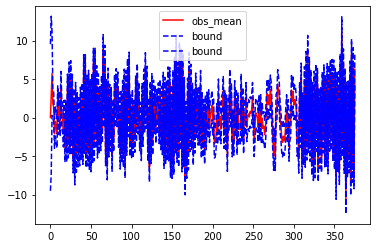

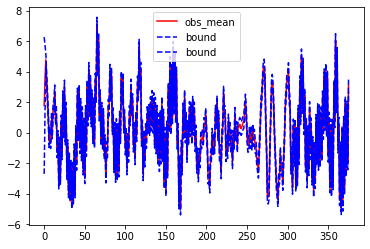

In [8]:
from tssltools import LGSS,kalman_filter

model = LGSS(T, R, Q, Z, H, a1, P1)
kf = kalman_filter(y,model)

state_mean = kf.alpha_filt

state_var = kf.P_filt

alpha_mean = [state_mean[0,0,t]+state_mean[1,0,t]+state_mean[2,0,t] for t in range(len(u))]
#v(a+b+c) = v(a)+v(b)+v(c)+2cov(ab)+2cov(ac)+2cov(bc)
alpha_var = [state_var[0,0,t]+state_var[1,1,t]+state_var[2,2,t]+2*state_var[1,2,t]+2*state_var[1,0,t]+2*state_var[0,2,t] for t in range(len(u))]
obs_mean = kf.y_pred
obs_var = kf.F_pred
plt.plot(u,obs_mean,c='r',label='obs_mean')
plt.plot(u,obs_mean+np.sqrt(obs_var),'--',c='b',label='bound')
plt.plot(u,obs_mean-np.sqrt(obs_var),'--',c='b',label='bound')
plt.legend()
plt.show()

plt.plot(u,alpha_mean,c='r',label='obs_mean')
plt.plot(u,alpha_mean+np.sqrt(alpha_var),'--',c='b',label='bound')
plt.plot(u,alpha_mean-np.sqrt(alpha_var),'--',c='b',label='bound')
plt.legend()
plt.show()

----

**c)** You are abit unsure about the values of $\sigma_{\eta}^2$ and $\sigma_{\varepsilon}^2$ and decide to retrain these parameters again. You remember that the EM-algorithm can be used for this problem, **describe the EM-algorithm briefly and find the updating formulas for the two variances**. To your help you have the complete-data log-likelihood,
$$
    \log p_{\theta}(\alpha_{1:n},y_{1:n}) = \text{const.} - \frac{1}{2}\sum_{i=1}^{n}\left[ \log \sigma_{\varepsilon}^2 + \log \sigma_{\eta}^2 + \varepsilon_{i}^{\top} \sigma_{\varepsilon}^{-2} \varepsilon_{i} + \eta_i^{\top} \sigma_{\eta}^{-2} \eta_i \right],
$$
where $\varepsilon_{i} = y_i - Z \alpha_i$ and $\eta_i = R^{\top} (\alpha_i - T \alpha_{i-1})$.
<div style="text-align: right"> (4p) </div>

**Solution:**

In [9]:
from tssltools import LGSS,kalman_smoother
def log_like(y,kf,model):
    cons = n*np.log(model.Q)+n*np.log(model.H)
    part1 = 0
    part2 = 0
    for i in range(1,376):
        sigma_i = y[i] - sum(model.Z*kf.alpha_filt[:,:,i])
        part1 = part1 + sigma_i.T * model.Q**-2 * sigma_i
        eta_i = sum(model.R.T*(kf.alpha_filt[:,:,i]-model.T@alpha_filt[:,:,i-1]))
        part2 = part2+ eta_i.T*model.H**-2*eta_i
    return -0.5*(cons+part1+part2)
    
num_iter = 50
log_like = np.zeros(num_iter)
theta = np.zeros((50,2))
theta[0,:] = (0.5**2,0.8**2) 
for i in range(1,num_iter):
    Q = np.array(theta[i-1,0])
    H = np.array(theta[i-1,1])
    model = LGSS(T, R, Q, Z, H, a1, P1)
    kf = kalman_filter(y,model)
    sm = kalman_smoother(y,model,kf)
    log_like[i] = log_like(y,kf,model)
    

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

## ---

**d)** Use the results from **c)** to implement the EM-algorithm and provide plots of the parameter trajectories for the two variances.

_hint: if you failed with **c)** you can use the function `theta_update_wrong` from `tssltools.py`. The Kalmans smoother is available in `tssltools.py`_
<div style="text-align: right"> (3p) </div>

**Solution:**